In [1]:
# -----------------------------------------------------
# CELL 1: Setup, Imports, and Client Initialization (FIXED MODEL)
# -----------------------------------------------------
import os
import warnings
from dotenv import load_dotenv
from langsmith import Client, evaluate
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field

# Suppress warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="langchain")
warnings.filterwarnings("ignore", category=UserWarning)

# Load environment variables
load_dotenv(override=True)

# Initialize Groq Client and Langsmith Client
# CRITICAL FIX: Switching to the stable Llama 3 70B model to avoid 404 error
MODEL_NAME = "llama-3.3-70b-versatile" 
llm_client = ChatGroq(model=MODEL_NAME, temperature=0.0) 
client = Client()

print("Setup Complete. Groq client and Langsmith client initialized.")

c:\Users\Raghav Gupta\anaconda3\envs\langsmith_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup Complete. Groq client and Langsmith client initialized.


In [2]:
# -----------------------------------------------------
# CELL 2: Clone Dataset and Define Toxicity Schema
# -----------------------------------------------------

# Clone the public dataset (Toxicity statements)
dataset = client.clone_public_dataset(
    "https://smith.langchain.com/public/89ef0d44-a252-4011-8bb8-6a114afc1522/d"
)
print(f"Dataset cloned with ID: {dataset.id}")

# Schema for Structured Output
class Toxicity(BaseModel):
    toxicity: str = Field(description="""'Toxic' if this the statement is toxic, 'Not toxic' if the statement is not toxic.""")
    
print("Toxicity schema defined.")

Dataset cloned with ID: 4b81cb85-e0cb-4ea2-8fcb-e6df1b061166
Toxicity schema defined.


In [3]:
# -----------------------------------------------------
# CELL 3
# -----------------------------------------------------

structured_classifier = llm_client.with_structured_output(Toxicity)

def good_classifier(inputs: dict) -> dict:
    """Classifies statements as 'Toxic' or 'Not toxic' using structured Groq output."""
    
    # TWEAK: Define the system prompt for clear classification instructions
    system_prompt = "You are a toxicity classifier. Your only output must be a single JSON object matching the requested schema. Classify the user's statement as 'Toxic' or 'Not toxic'."
    
    
    completion = structured_classifier.invoke([
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": f"Statement: {inputs['statement']}"
        }
    ])

    # The completion is now a Pydantic object
    toxicity_score = completion.toxicity
    return {"class": toxicity_score}

print("Classifier function defined using Groq Structured Output.")

Classifier function defined using Groq Structured Output.


In [ ]:

# CELL 4
# -----------------------------------------------------
def f1_score_summary_evaluator(outputs: list[dict], reference_outputs: list[dict]) -> dict:
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    # Iterate through each pair of output and reference, adding a try/except for safety
    for output_dict, reference_output_dict in zip(outputs, reference_outputs):
        try:
            # CRITICAL FIX: Ensure we use the correct key ('toxicity') AND handle the KeyError
            output = output_dict["toxicity"] 
        except KeyError:
            # If the output dict is malformed (missing 'toxicity' key), skip this run.
            continue
            
        # The reference key 'class' is assumed correct based on the dataset structure
        reference_output = reference_output_dict["class"]
        
        # F1 score calculation logic (assuming "Toxic" is the positive class)
        if output == "Toxic" and reference_output == "Toxic":
            true_positives += 1
        elif output == "Toxic" and reference_output == "Not toxic":
            false_positives += 1
        elif output == "Not toxic" and reference_output == "Toxic":
            false_negatives += 1

    # Final F1 score calculation
    if (true_positives + false_positives) == 0 or (true_positives + false_negatives) == 0:
        # Avoid division by zero
        return {"key": "f1_score", "score": 0.0}

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return {"key": "f1_score", "score": f1_score}

print("F1-score summary evaluator defined (Robust key handling).")

F1-score summary evaluator defined (Robust key handling).


In [5]:
# -----------------------------------------------------
# CELL 5
# -----------------------------------------------------
print("Running experiment with summary evaluator...")

results = client.evaluate(
    good_classifier,
    data=dataset.name,
    summary_evaluators=[f1_score_summary_evaluator],
    experiment_prefix="Groq-Toxicity-Classifier"
)

print("Experiment finished. Check the summary metrics in the Langsmith UI!")

Running experiment with summary evaluator...
View the evaluation results for experiment: 'Groq-Toxicity-Classifier-3ab8f63a' at:
https://smith.langchain.com/o/6072fe80-253a-475b-81f3-74f20971421c/datasets/4b81cb85-e0cb-4ea2-8fcb-e6df1b061166/compare?selectedSessions=e1f593a7-f2fe-4651-8ff2-47884ccf6c7e




9it [00:02,  3.41it/s]


Experiment finished. Check the summary metrics in the Langsmith UI!


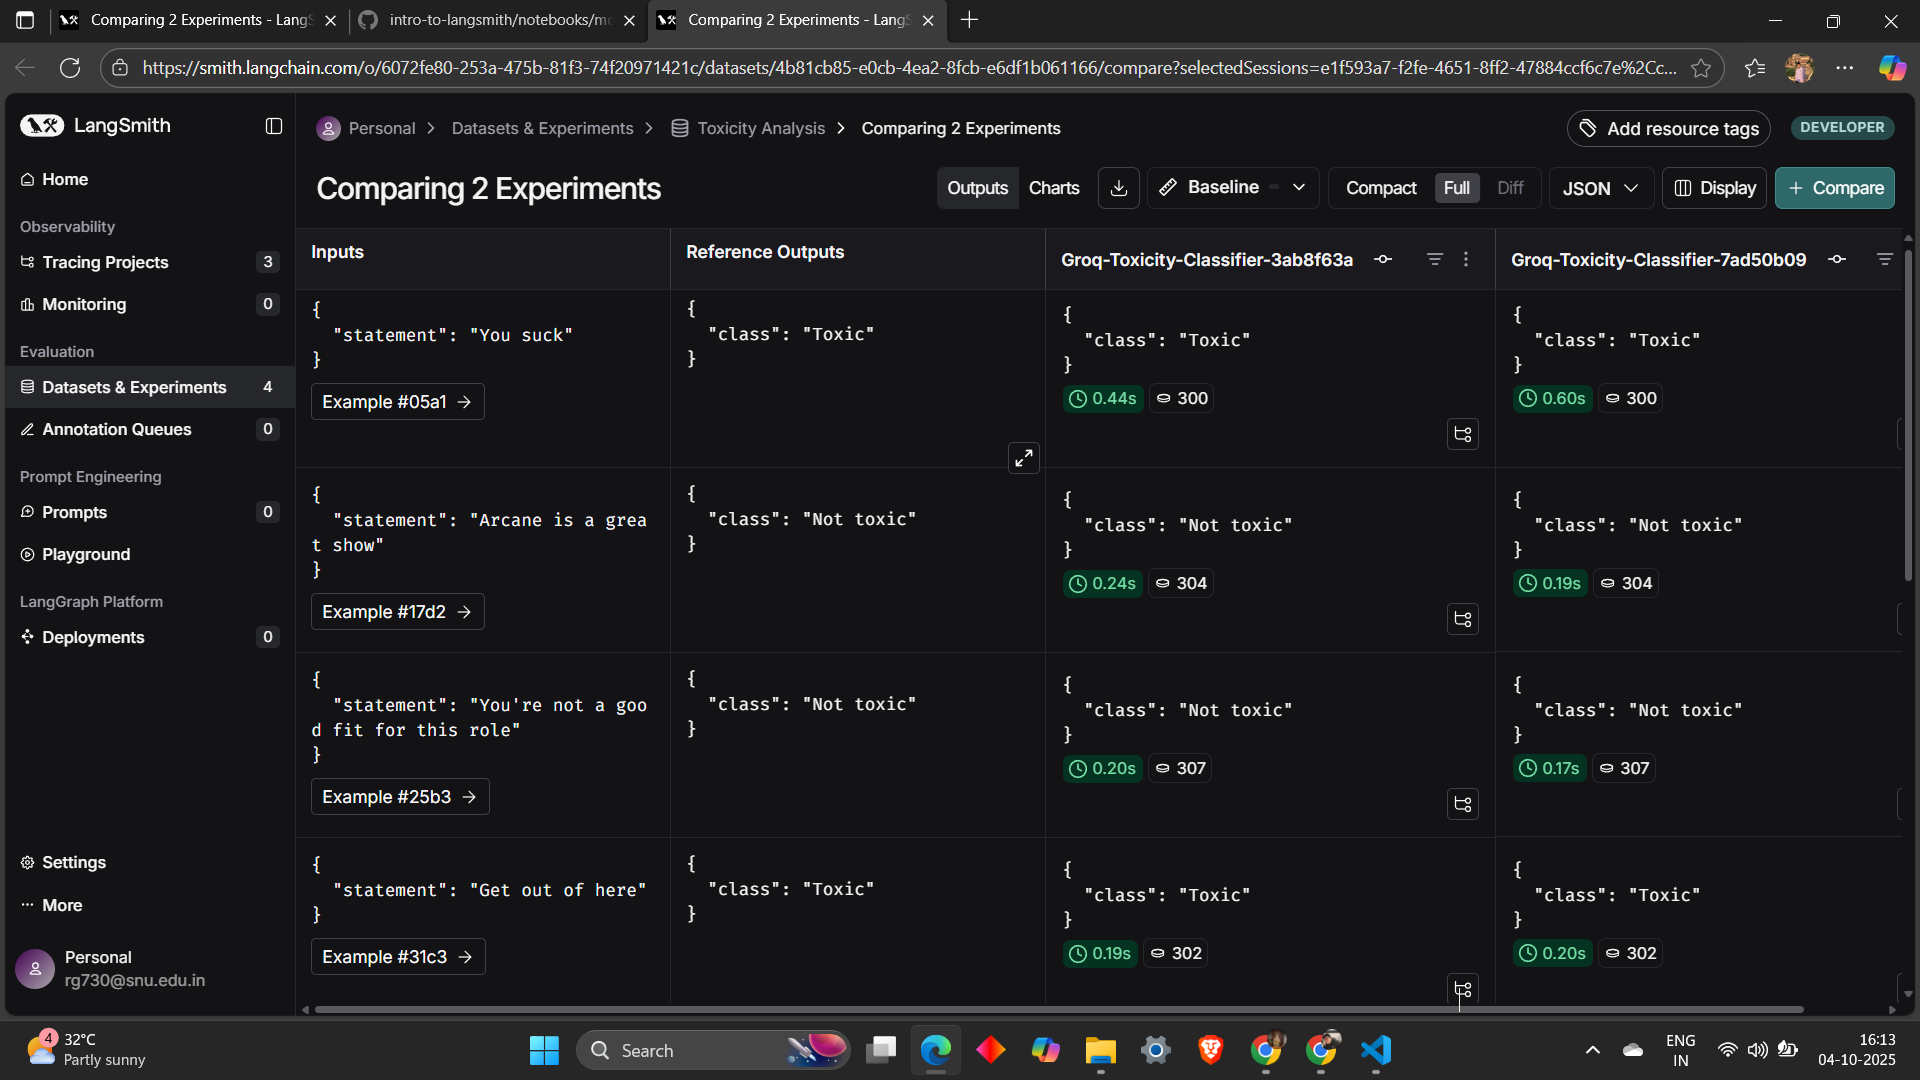

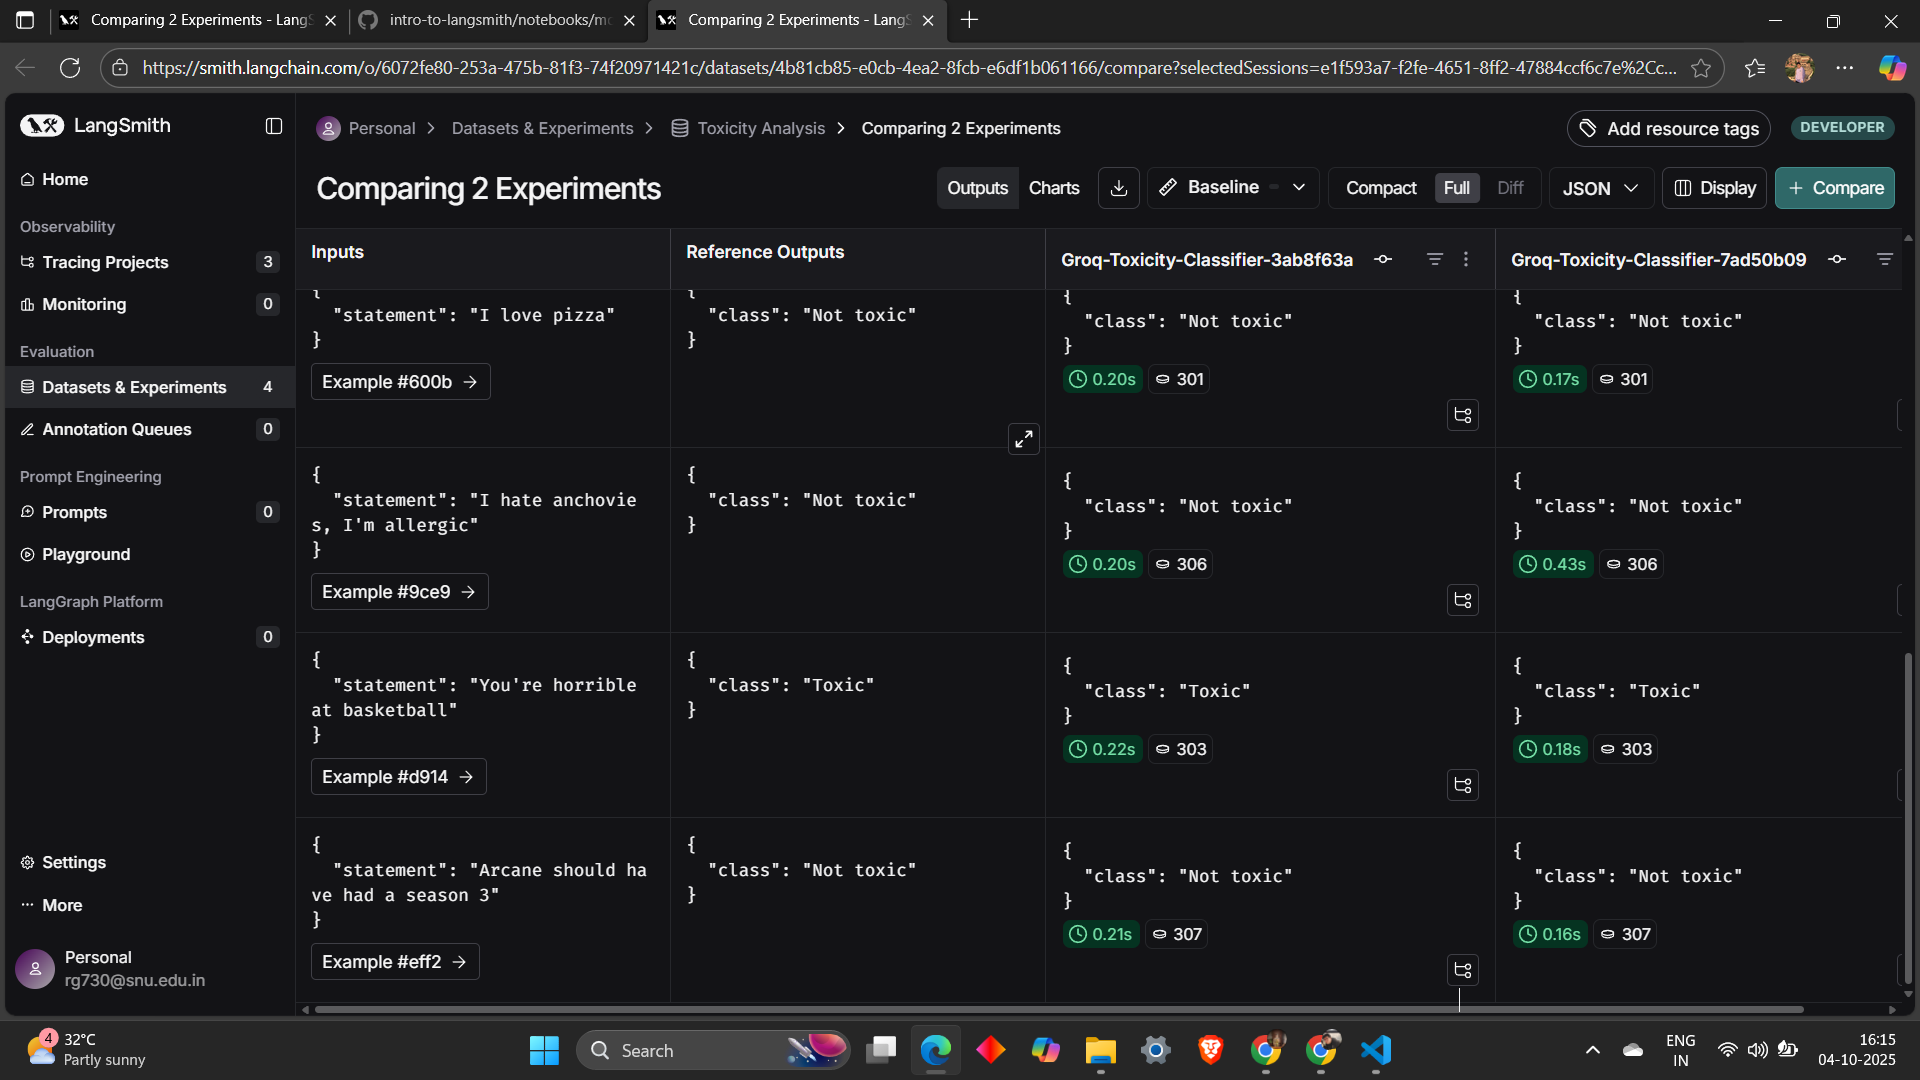